<a href="https://colab.research.google.com/github/minzadinov/HPC-2023/blob/main/harris/harris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import cv2
import cupy as cp
import numpy as np
from matplotlib import pyplot as plt
import time
from google.colab.patches import cv2_imshow

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def harris_cpu(image, window_size, k, threshold, time_test=False):

    img = image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(3,3),0)

    height = img.shape[0]   # высота
    width = img.shape[1]    # ширина
    matrix_R = np.zeros((height,width))

    # Вычисление dx dy
    dx = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)

    # Вычисание dx2 dy2 dxy
    dx2=np.square(dx)
    dy2=np.square(dy)
    dxy=dx*dy
    offset = int( window_size / 2 )

    # Вычисление элементов матрицы
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            Sx2 = np.sum(dx2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sy2 = np.sum(dy2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sxy = np.sum(dxy[y-offset:y+1+offset, x-offset:x+1+offset])
            #   Шаг 4 - Задание матрицы H(x,y)=[[Sx2,Sxy],[Sxy,Sy2]]
            H = np.array([[Sx2,Sxy],[Sxy,Sy2]])

            #   Шаг 5 - Вычисление значения R
            det=np.linalg.det(H)
            tr=np.matrix.trace(H)
            R=det-k*(tr**2)
            matrix_R[y-offset, x-offset]=R

# Сравнение с пороговым значением
    cv2.normalize(matrix_R, matrix_R, 0, 1, cv2.NORM_MINMAX)
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            value=matrix_R[y, x]
            if value>threshold:
                cv2.circle(img,(x,y),1,(0,0,255))

    if time_test==False:
      f1 = plt.figure("Manually implemented Harris detector")
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Manually implemented Harris detector")
      plt.xticks([]), plt.yticks([])
      plt.savefig('My_harris_detector-thresh_%s.png'%(threshold), bbox_inches='tight')
      f1.show()


In [8]:
def harris_gpu(image, window_size, k, threshold, time_test=False):
    img = image
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_gaussian = cv2.GaussianBlur(gray,(3,3),0)

    height = img.shape[0]   # высота
    width = img.shape[1]    # ширина

    # Вычисление dx dy
    dx = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)

    # Вычисание dx2 dy2 dxy
    dx2=np.square(dx)
    print(dx2.shape, 'shape')
    dy2=np.square(dy)
    dxy=dx*dy

    offset = int( window_size / 2 )
    # Вычисление элементов матрицы
    dx2_gpu = cp.asarray(dx2.flatten())
    dy2_gpu = cp.asarray(dy2.flatten())
    dxy_gpu = cp.asarray(dxy.flatten())
    matrix_R_gpu = cp.zeros((height*width,))
    # Объявление ядра для вычисления матрицы R
    kernel = cp.RawKernel(r'''
    extern "C" __global__
    void compute_R(const double* dx2, const double* dy2, const double* dxy, double* matrix_R, const int width, const int height, const int offset, const double k) {
    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;

    if (x >= offset && x < width - offset && y >= offset && y < height - offset) {
        double Sx2 = 0;
        double Sy2 = 0;
        double Sxy = 0;

        for (int j = y - offset; j <= y + offset; j++) {
            for (int i = x - offset; i <= x + offset; i++) {
                Sx2 += dx2[j * width + i];
                Sy2 += dy2[j * width + i];
                Sxy += dxy[j * width + i];
            }
        }
        double H[2][2] = {{Sx2, Sxy}, {Sxy, Sy2}};
        double det = H[0][0]*H[1][1] - H[0][1]*H[1][0];
        double tr = H[0][0] + H[1][1];
        double R = det - k*(tr*tr);
        matrix_R[y * width + x] = R;
    }
    }
    ''', 'compute_R')

    kernel((32, 32), (32, 32), (dx2_gpu, dy2_gpu, dxy_gpu, matrix_R_gpu, width, height, offset, k))

    matrix_R = np.array(matrix_R_gpu.get()).reshape(height, width)

    # Сравнение с пороговым значением
    cv2.normalize(matrix_R, matrix_R, 0, 1, cv2.NORM_MINMAX)
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            value=matrix_R[y, x]
            if value>threshold:
                cv2.circle(img,(x,y),1,(0,0,255))

    if time_test==False:
      f2 = plt.figure("Manually implemented Harris detector using CUDA")
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Manually implemented Harris detector using CUDA")
      plt.xticks([]), plt.yticks([])
      plt.savefig('CUDA_harris_detector-thresh_%s.png'%(threshold), bbox_inches='tight')
      f2.show()

In [9]:
def cpu_with_time (image, window_size, k, threshold):
  start_time = time.time()
  harris_cpu(image, window_size, k, threshold, time_test=True)
  end_time = time.time()
  execution_time = end_time - start_time
  return execution_time

def gpu_with_time (image, window_size, k, threshold):
  start_time = time.time()
  harris_gpu(image, window_size, k, threshold, time_test=True)
  end_time = time.time()
  execution_time = end_time - start_time
  return execution_time

There is 3 images with shapes
(900, 1200)
(1742, 1125)
(1920, 2560)
Here they are:


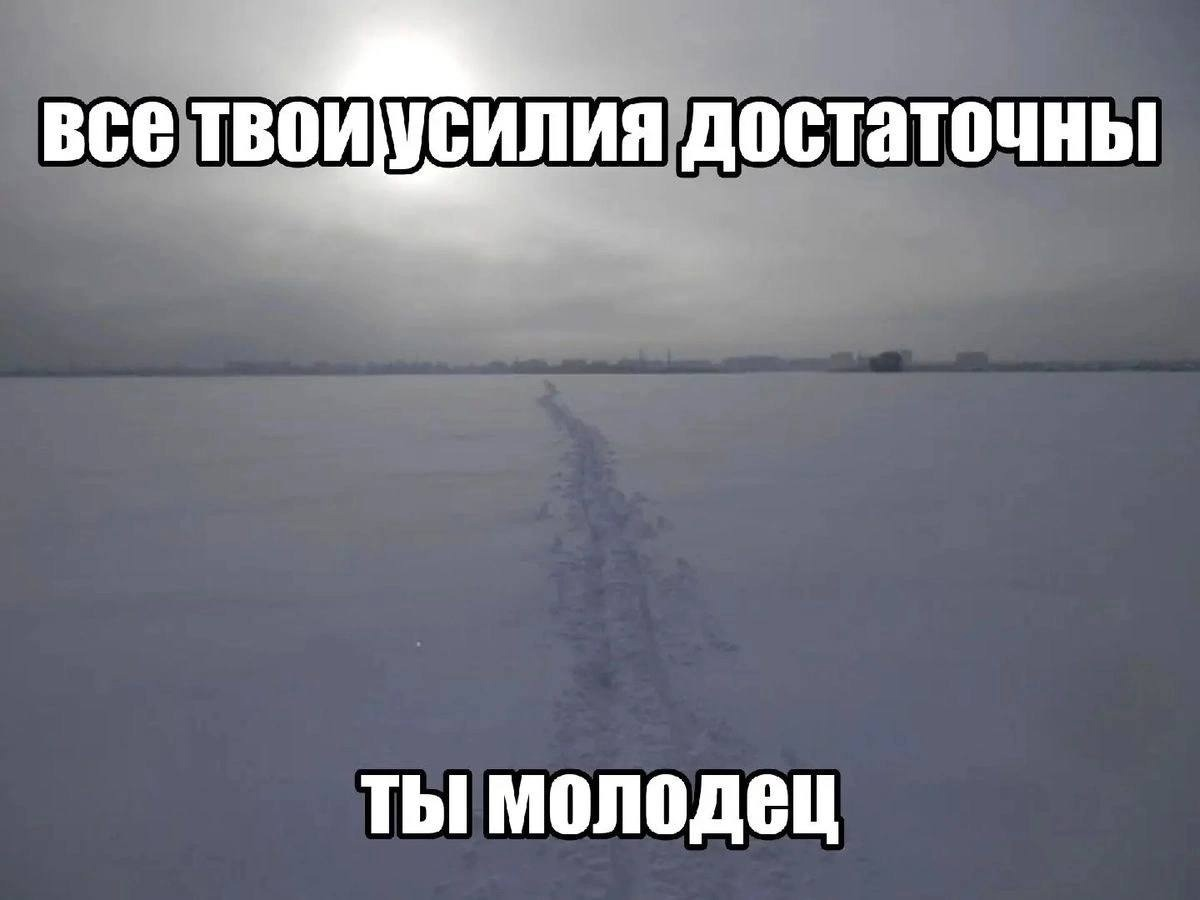

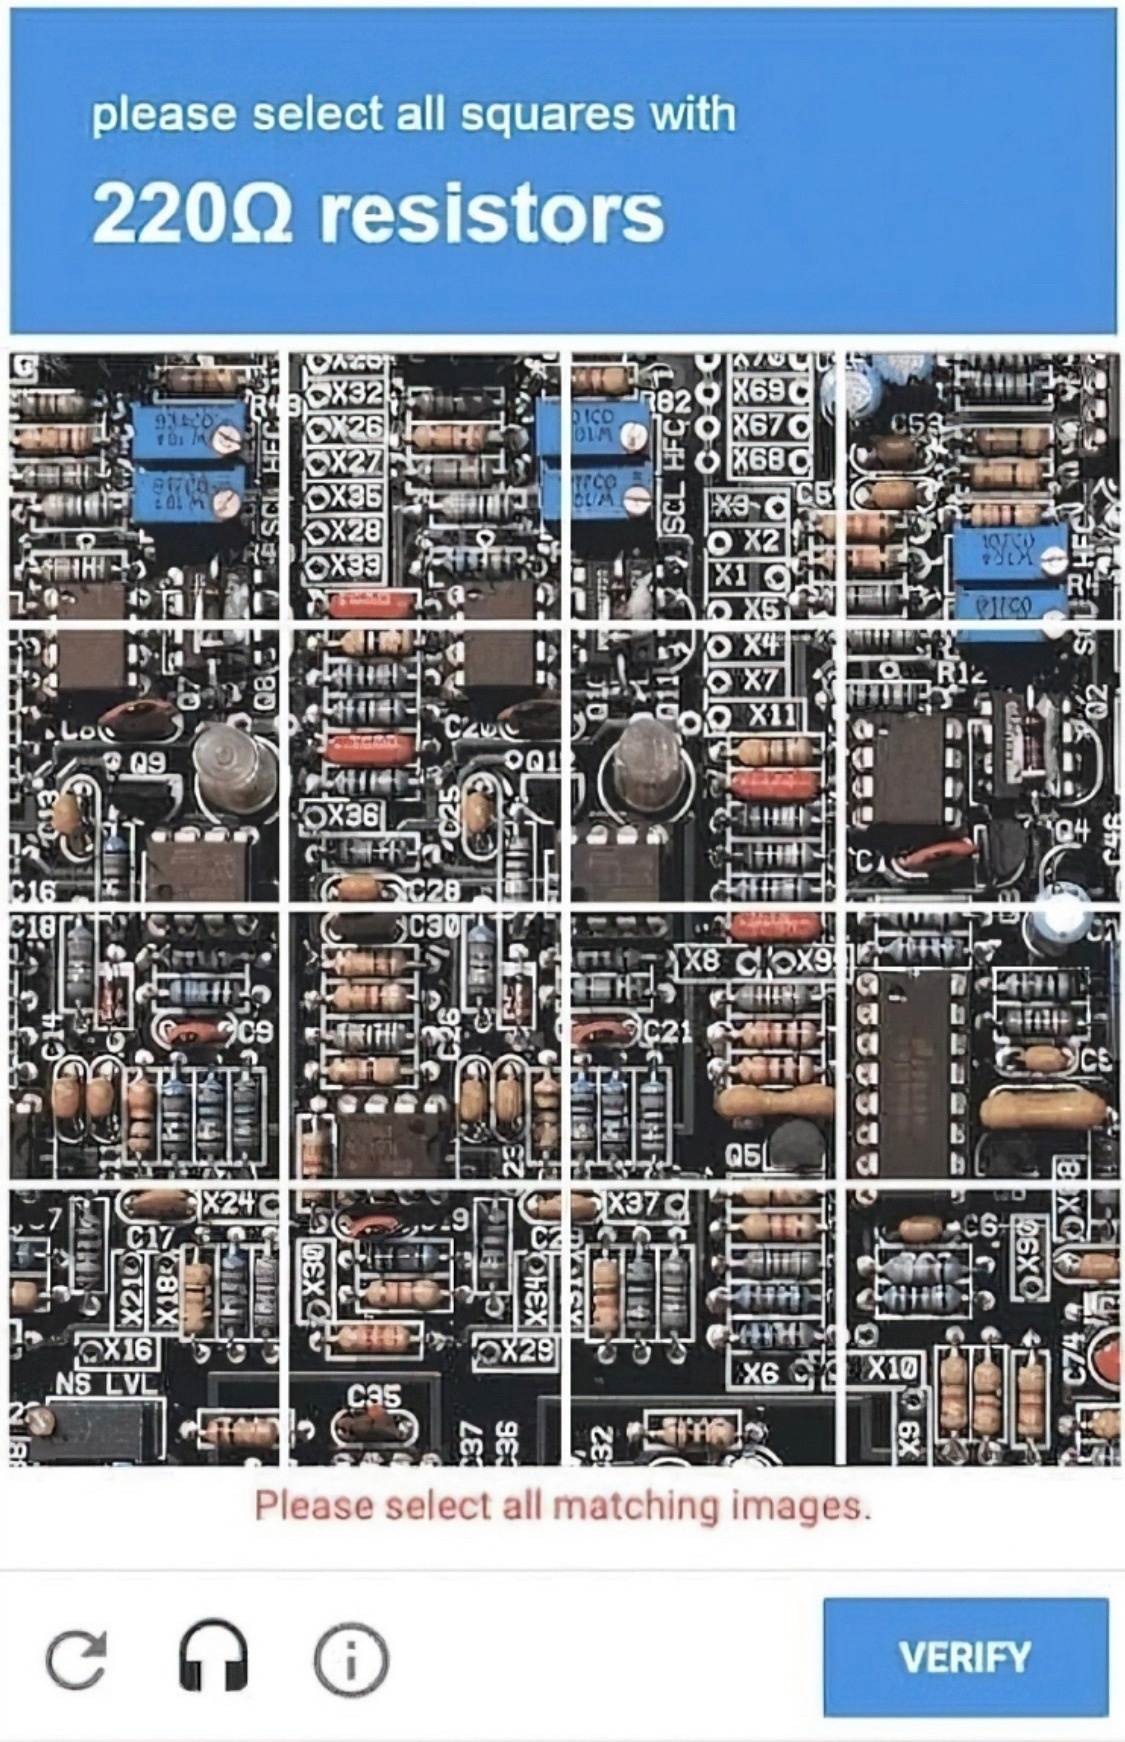

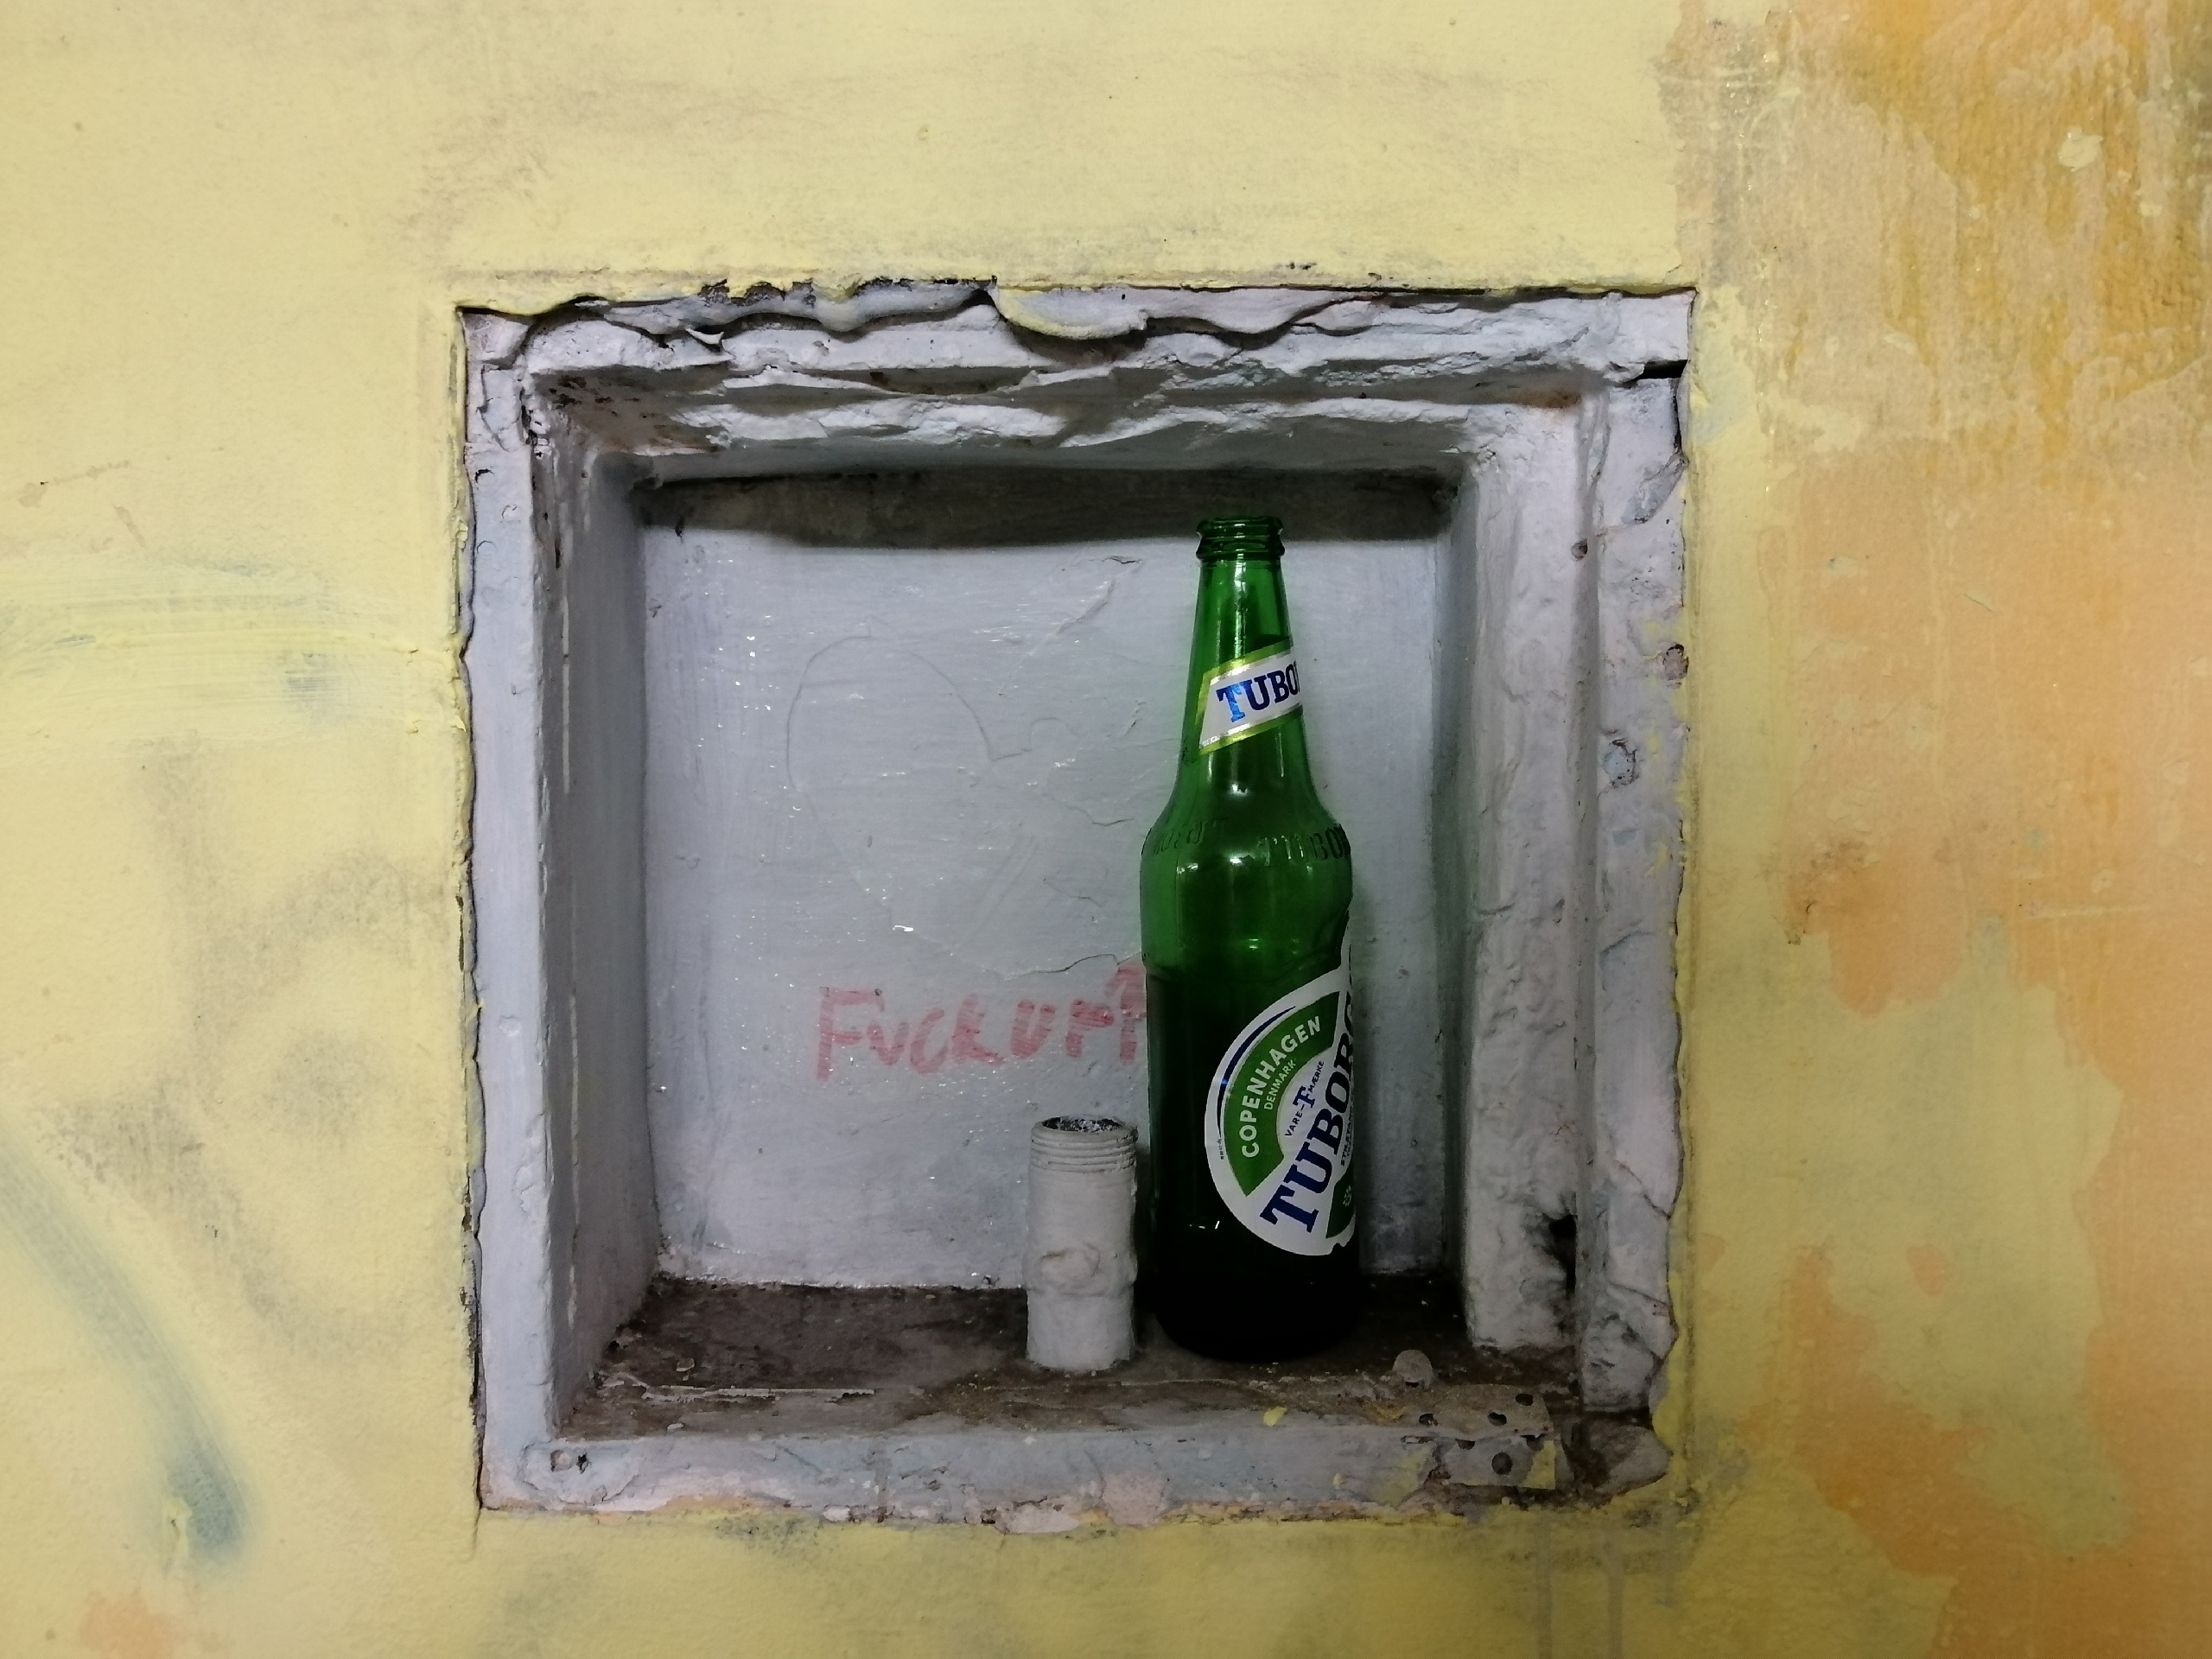

In [26]:
number_of_images = 3
image_read = lambda index: cv2.imread('/content/drive/MyDrive/HPC/harris/image_%s.jpg'%(index))

image_list = [image_read(i) for i in range(1,number_of_images+1)]
print('There is', len(image_list), 'images with shapes')

image_shapes = []
for i in image_list:
  image_shapes.append(i.shape[:2])
  print(i.shape[:2])

print('Here they are:')
for i in image_list:
  cv2_imshow(i)

In [27]:
window_size = 8
k = 0.04
threshold=0.45

cpu_times = []
gpu_times = []

for image in image_list:
  cpu_times.append(cpu_with_time(image, window_size, k, threshold))
  gpu_times.append(cpu_with_time(image, window_size, k, threshold))

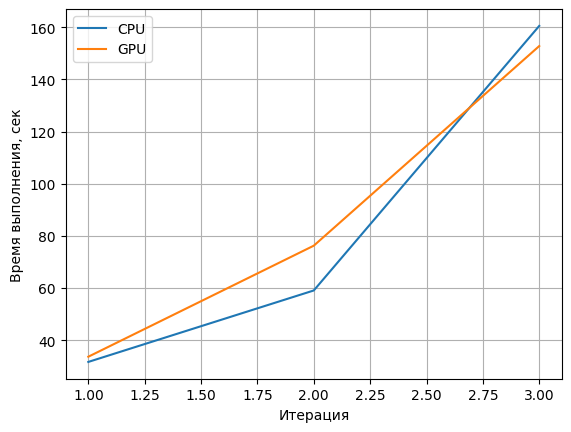

In [28]:
iter_list=range(1,number_of_images+1)
label_x="Итерация"
label_y="Время выполнения, сек"

plt.plot(iter_list, cpu_times, label='CPU')
plt.legend()
plt.plot(iter_list, gpu_times, label='GPU')
plt.legend()
plt.grid()
plt.xlabel(label_x)
plt.ylabel(label_y)

plt.savefig("/content/drive/MyDrive/HPC/harris/harris_plot.png")
plt.show()